In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [8]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [10]:
grouped_res.loc[2, :]

frac_valid                            accuracy  \
                                mean       std count       sem      mean   
representation train_size                                                  
InChI          10           1.000000  0.000000     5  0.000000  0.575200   
               50           1.000000  0.000000     6  0.000000  0.629333   
               100          1.000000  0.000000     6  0.000000  0.641333   
               200          1.000000  0.000000     7  0.000000  0.665143   
               500          1.000000  0.000000     7  0.000000  0.686857   
               1000         1.000000       NaN     1       NaN  0.644000   
SELFIES        10           1.000000  0.000000     5  0.000000  0.532000   
               50           1.000000  0.000000     6  0.000000  0.588667   
               100          1.000000  0.000000     6  0.000000  0.640667   
               200          1.000000  0.000000     7  0.000000  0.655429   
               500          1.000000  0.000000     7  0.000000  0.693714   
               1000         1.000000       NaN     1       NaN  0.696000   
SMILES         10           1.000000  0.000000     6  0.000000  0.556000   
               50           1.000000  0.000000     6  0.000000  0.604667   
               100          1.000000  0.000000     6  0.000000  0.656667   
               200          1.000000  0.000000     7  0.000000  0.672000   
               500          0.999429  0.001512     7  0.000571  0.712989   
               1000         1.000000       NaN     1       NaN  0.704000   

                                                     f1_macro                  \
                                std count       sem      mean       std count   
representation train_size                                                       
InChI          10          0.035259     5  0.015768  0.545902  0.061179     5   
               50          0.031665     6  0.012927  0.627607  0.031263     6   
               100         0.032758     6  0.013373  0.639803  0.032346     6   
               200         0.035979     7  0.013599  0.664192  0.036048     7   
               500         0.023745     7  0.008975  0.686309  0.023714     7   
               1000             NaN     1       NaN  0.643309       NaN     1   
SELFIES        10          0.052839     5  0.023630  0.497670  0.099056     5   
               50          0.048492     6  0.019797  0.584492  0.052911     6   
               100         0.043038     6  0.017570  0.638557  0.043888     6   
               200         0.030588     7  0.011561  0.653304  0.030872     7   
               500         0.035989     7  0.013603  0.693573  0.036013     7   
               1000             NaN     1       NaN  0.696000       NaN     1   
SMILES         10          0.041569     6  0.016971  0.506474  0.088092     6   
               50          0.052728     6  0.021526  0.602294  0.054599     6   
               100         0.035001     6  0.014289  0.653083  0.036228     6   
               200         0.023551     7  0.008902  0.670419  0.022849     7   
               500         0.022328     7  0.008439  0.712637  0.022706     7   
               1000             NaN     1       NaN  0.703924       NaN     1   

                                     f1_micro                            \
                                sem      mean       std count       sem   
representation train_size                                                 
InChI          10          0.027360  0.575200  0.035259     5  0.015768   
               50          0.012763  0.629333  0.031665     6  0.012927   
               100         0.013205  0.641333  0.032758     6  0.013373   
               200         0.013625  0.665143  0.035979     7  0.013599   
               500         0.008963  0.686857  0.023745     7  0.008975   
               1000             NaN  0.644000       NaN     1       NaN   
SELFIES        10          0.044299  0.532000  0.052

In [11]:
grouped_tabpfn_res

accuracy                      f1_macro            \
                            mean       std       sem      mean       std   
num_classes train_size                                                     
2           10          0.558105  0.028825  0.006613  0.549658  0.036467   
            50          0.560571  0.029183  0.006368  0.557362  0.032043   
            100         0.578667  0.025592  0.005585  0.577997  0.025507   
            200         0.608500  0.026672  0.005444  0.608003  0.026953   
            500         0.623826  0.044648  0.009310  0.622791  0.045458   
            1000        0.644000  0.000000  0.000000  0.643858  0.000000   
5           10          0.220000  0.029148  0.006361  0.207449  0.033101   
            50          0.236000  0.026833  0.005855  0.228163  0.024369   
            100         0.257714  0.034002  0.007420  0.238201  0.038085   
            200         0.296400  0.030516  0.006823  0.273130  0.035190   
            500         0.340000  0.025267  0.005514  0.310946  0.022472   
            1000        0.300000  0.000000  0.000000  0.288270  0.000000   

                                  f1_micro                         kappa  \
                             sem      mean       std       sem      mean   
num_classes train_size                                                     
2           10          0.008366  0.558105  0.028825  0.006613  0.116211   
            50          0.006992  0.560571  0.029183  0.006368  0.121143   
            100         0.005566  0.578667  0.025592  0.005585  0.157333   
            200         0.005502  0.608500  0.026672  0.005444  0.217000   
            500         0.009479  0.623826  0.044648  0.009310  0.247652   
            1000        0.000000  0.644000  0.000000  0.000000  0.288000   
5           10          0.007223  0.220000  0.029148  0.006361  0.025000   
            50          0.005318  0.236000  0.026833  0.005855  0.045000   
            100         0.008311  0.257714  0.034002  0.007420  0.072143   
            200         0.007869  0.296400  0.030516  0.006823  0.120500   
            500         0.004904  0.340000  0.025267  0.005514  0.175000   
            1000        0.000000  0.300000  0.000000  0.000000  0.125000   

                                            
                             std       sem  
num_classes train_size                      
2           10          0.057650  0.013226  
            50          0.058366  0.012737  
            100         0.051183  0.011169  
            200         0.053344  0.010889  
            500         0.089296  0.018619  
            1000        0.000000  0.000000  
5           10          0.036435  0.007951  
            50          0.033541  0.007319  
            100         0.042502  0.009275  
            200         0.038144  0.008529  
            500         0.031583  0.006892  
            1000        0.000000  0.000000

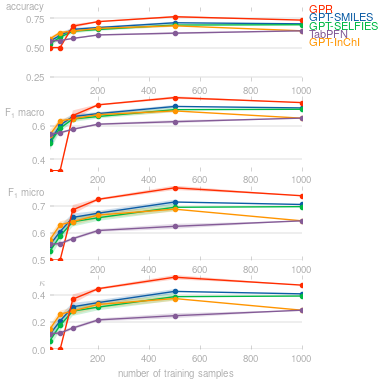

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, "SMILES", :].index,
            grouped_res.loc[2, "SMILES", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "SMILES", :].index,
            grouped_res.loc[2, "SMILES", :][metric]["mean"]
            - grouped_res.loc[2, "SMILES", :][metric]["sem"],
            grouped_res.loc[2, "SMILES", :][metric]["mean"]
            + grouped_res.loc[2, "SMILES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "SELFIES", :].index,
            grouped_res.loc[2, "SELFIES", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "SELFIES", :].index,
            grouped_res.loc[2, "SELFIES", :][metric]["mean"]
            - grouped_res.loc[2, "SELFIES", :][metric]["sem"],
            grouped_res.loc[2, "SELFIES", :][metric]["mean"]
            + grouped_res.loc[2, "SELFIES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "InChI", :].index,
            grouped_res.loc[2, "InChI", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "InChI", :].index,
            grouped_res.loc[2, "InChI", :][metric]["mean"]
            - grouped_res.loc[2, "InChI", :][metric]["sem"],
            grouped_res.loc[2, "InChI", :][metric]["mean"]
            + grouped_res.loc[2, "InChI", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            - grouped_xgboost_res.loc[2, :][metric]["sem"],
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            + grouped_xgboost_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, :][metric]["sem"],
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    ax[-1].set_xlabel("number of training samples", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)
    ax[0].set_ylim(0.21, 0.85)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    fig.savefig("bandgap-classification_results_2_class.pdf", bbox_inches="tight")

In [13]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

7.759209240399953

In [14]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.9717279319051408

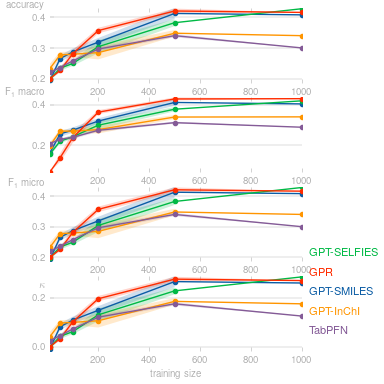

In [15]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, "SMILES", :].index,
            grouped_res.loc[5, "SMILES", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "SMILES", :].index,
            grouped_res.loc[5, "SMILES", :][metric]["mean"]
            - grouped_res.loc[5, "SMILES", :][metric]["sem"],
            grouped_res.loc[5, "SMILES", :][metric]["mean"]
            + grouped_res.loc[5, "SMILES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "SELFIES", :].index,
            grouped_res.loc[5, "SELFIES", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "SELFIES", :].index,
            grouped_res.loc[5, "SELFIES", :][metric]["mean"]
            - grouped_res.loc[5, "SELFIES", :][metric]["sem"],
            grouped_res.loc[5, "SELFIES", :][metric]["mean"]
            + grouped_res.loc[5, "SELFIES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "InChI", :].index,
            grouped_res.loc[5, "InChI", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "InChI", :].index,
            grouped_res.loc[5, "InChI", :][metric]["mean"]
            - grouped_res.loc[5, "InChI", :][metric]["sem"],
            grouped_res.loc[5, "InChI", :][metric]["mean"]
            + grouped_res.loc[5, "InChI", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    ax[-1].set_xlabel("training size", labelpad=4)
    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    fig.savefig("bandgap-classification_results_5_class.pdf", bbox_inches="tight")